# Train test split and cross validation for model selection, parameter tuning, and feature selection

- How do I estimate the **likely performance of my model** on out-of-sample data?
- What is the drawback of using the **train/test split** procedure for model evaluation?
- How can cross-validation be used for selecting **tuning parameters**, choosing between **models**, and selecting **features**?
- How can K-fold cross-validation be used to search for an **optimal tuning parameter**?
- How can this process be made **more efficient**?
- How do you search for **multiple tuning parameters** at once?
- How can the **computational expense** of this process be reduced?

## Model evaluation procedures

**Motivation:** Need a way to choose between machine learning models

- Goal is to estimate likely performance of a model on **out-of-sample data**

**Initial idea:** Train and test on the same data

- But, maximizing **training accuracy** rewards overly complex models which **overfit** the training data

**Alternative idea:** Train/test split

- Split the dataset into two pieces, so that the model can be trained and tested on **different data**
- **Testing accuracy** is a better estimate than training accuracy of out-of-sample performance
- But, it provides a **high variance** estimate since changing which observations happen to be in the testing set can significantly change testing accuracy

## Model evaluation procedures

1. Train the model on the **entire dataset**.
2. Test the model on the **same dataset**, and evaluate how well we did by comparing the **predicted** response values with the **true** response values.

In [1]:
from __future__ import print_function

In [2]:
# all of the imports
import pandas as pd
import numpy as np
import pickle 
import patsy
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import KFold
% matplotlib inline

import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
# let's go back to our fake data from yesterday: 

data=np.load('../03-regression_statsmodels/data/poly_data.npz')
X=data['arr_0']
y=data['arr_1']


# Function that returns the sin(2*pi*x)
def f(x):
    return np.sin(2 * np.pi * x)


# Plot the results of a pipeline against ground truth and actual data
def plot_approximation(est, ax, label=None):
    """Plot the approximation of ``est`` on axis ``ax``. """
    ax.plot(x_plot, f(x_plot), label='ground truth', color='green')
    ax.scatter(X, y, s=100)
    ax.plot(x_plot, est.predict(x_plot[:, np.newaxis]), color='red', label=label)
    ax.set_ylim((-2, 2))
    ax.set_xlim((0, 1))
    ax.set_ylabel('y')
    ax.set_xlabel('x')
    ax.legend(loc='upper right',frameon=True)
    
x_plot = np.linspace(0, 1, 100)

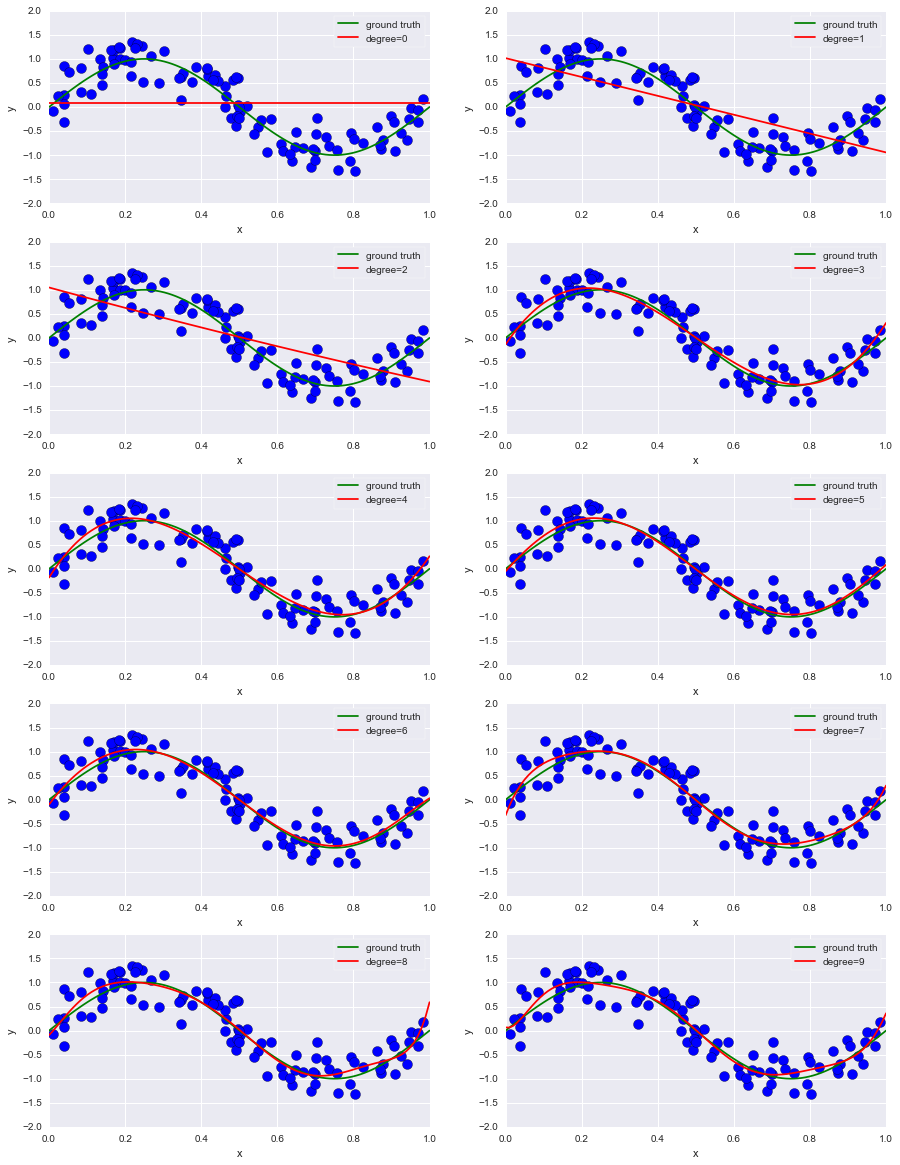

In [4]:
fig, ax_rows = plt.subplots(5, 2, figsize=(15, 20))
for degree in range(10):
    est = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    est.fit(X, y)
    # This sets the appropriate axis for each degree (KEEP)
    ax_row_left, ax_row_right = ax_rows[degree/2]
    if degree%2 == 0:
        ax = ax_row_left
    else:
        ax = ax_row_right
    plot_approximation(est, ax, label='degree=%d' % degree)

### Cross-Validated Regression
As you probably guessed, the problem with our model above was that we trained and tested our model on the same dataset.  This means our model could be very likely to **overfit** and not perform as well when it tries to **generalize** to real world data, and after all ***generalization is the key to machine learning***.

Thus, we have a need for **cross-validation** in our model evaluation process.  That is, we need to find a way to train our model on 1 randomly chosen set of data and evaluate it against a separate random test set.  Thankfully sklearn provides a bevy of built-in ways to perform cross-validation.

#### Cross-Validation with sklearn
The simplest way to perform cross-validation with an sklearn model is to have it perform a random **train/test split** of the data for you.  It's customary to use something like 2/3 of your data for training, and the remaining 1/3 for testing.  

sklearn's [***train_test_split***](http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.train_test_split.html) function provides exactly that.  Here's an example of it in action.

In [5]:
lr = LinearRegression()
# INSTRUCTOR NOTE: Run this multiple times to show the variation
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
# Fit the model against the training data
lr.fit(X_train, y_train)
# Evaluate the model against the testing data
lr.score(X_test, y_test)

0.53927554902149089

**What have we done?**
We've now scored our trained model against a test set.  How can we see the value of this?  Well let's remind ourselves of the score that we got by scoring against the training set by doing that again:

In [6]:
lr1 = LinearRegression()
lr1.fit(X, y)
lr1.score(X, y)

0.53989738881604232

**Whoa!**

Now we can begin to see the value of a hold out test set.  Notice that our model performance is significantly decreased on the test set.  This is **okay!**  In fact, this is better as we now have a much more accurate number to report regarding probable model performance in the real world, and we won't be making false promises to our CEO :)

There are a variety of ways to do cross-validation, and sklearn's modules for handling this can be found [here](http://scikit-learn.org/dev/modules/cross_validation.html)

## Next Step : Cross-Validation

Steps for cross-validation:

- Dataset is split into K "folds" of **equal size**
- Each fold acts as the **testing set** 1 time, and acts as the **training set** K-1 times
- **Average testing performance** is used as the estimate of out-of-sample performance

Benefits of cross-validation:

- More **reliable** estimate of out-of-sample performance than train/test split
- Can be used for selecting **tuning parameters**, choosing between **models**, and selecting **features**

Drawbacks of cross-validation:

- Can be computationally **expensive**

## Steps for K-fold cross-validation

1. Split the dataset into K **equal** partitions (or "folds").
2. Use fold 1 as the **testing set** and the union of the other folds as the **training set**.
3. Calculate **testing accuracy**.
4. Repeat steps 2 and 3 K times, using a **different fold** as the testing set each time.
5. Use the **average testing accuracy** as the estimate of out-of

Diagram of **5-fold cross-validation:**

![5-fold cross-validation](images/07_cross_validation_diagram.png)

## Comparing cross-validation to train/test split

Advantages of **cross-validation:**

- More accurate estimate of out-of-sample accuracy
- More "efficient" use of data (every observation is used for both training and testing)

Advantages of **train/test split:**

- Runs K times faster than K-fold cross-validation
- Simpler to examine the detailed results of the testing process

## Cross-validation recommendations

1. K can be any number, but **K=10** is generally recommended
2. For classification problems, **stratified sampling** is recommended for creating the folds 
    - Each response class should be represented with equal proportions in each of the K folds
    - scikit-learn's `cross_val_score` function does this by default

In [7]:
from sklearn.cross_validation import cross_val_score

In [8]:
# 10-fold cross-validation with our fake data
reg = LinearRegression()
scores = cross_val_score(reg, X, y, cv=10, scoring='mean_squared_error')

# scores output is negative, a sklearn quirk bc mse is used to min. optimization func.
print(-scores)

[ 0.20974773  0.31621288  0.31173906  0.28077603  0.21117244  0.25253105
  0.21507221  0.18176902  0.28324608  0.4035005 ]


### Now apply to car data

- Import cars2frame.pkl from yesterday
- Compare R^2 score when trained on the entire data set vs the test-train-split method  

In [9]:
# STUDENT SECTION

cars=pd.read_pickle('data/cars2frame.pkl')
cars.head(1)

,length,width,height,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,...,make[T.nissan],make[T.peugot],make[T.plymouth],make[T.porsche],make[T.renault],make[T.saab],make[T.subaru],make[T.toyota],make[T.volkswagen],make[T.volvo]
0,168.8,64.1,48.8,3.47,2.68,9.0,111.0,5000.0,21,27,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
y = cars.log_price
X=cars.drop(['log_price','price'],1)

model= LinearRegression()
model.fit(X,y)
model.score(X,y)

0.95502987130220229

In [11]:
# using cross validation
X_train, X_test, y_train, y_test = train_test_split(X, y)
model.fit(X_train,y_train)
model.score(X_test,y_test)


0.89580939189840836

In [12]:
# Student Exercise : Use cross validation for feature selection on the car data 
# 5-fold cross-validation ( As mentioned above, 10-fold is typically ideal, but this is a relatively small data set)
# Use r2 as the scoring criteria, 
# Note the Improvement guidelines below

In [13]:
# STUDENT SECTION

# Read in the pickle file


In [14]:
# Let's start with filtering features using p-value: 



## Improvements to cross-validation

**Repeated cross-validation**

- Repeat cross-validation multiple times (with **different random splits** of the data) and average the results
- More reliable estimate of out-of-sample performance by **reducing the variance** associated with a single trial of cross-validation

**Creating a hold-out set**

- "Hold out" a portion of the data **before** beginning the model building process
- Locate the best model using cross-validation on the remaining data, and test it **using the hold-out set**
- More reliable estimate of out-of-sample performance since hold-out set is **truly out-of-sample**

**Feature engineering and selection within cross-validation iterations**

- Perform all feature engineering and selection **within each cross-validation iteration**
- More reliable estimate of out-of-sample performance since it **better mimics** the application of the model to out-of-sample data